In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/rasa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [220]:
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
    for word in str(text).split():
        word = word.lower()
        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)
    return output

punctuations_list = string.punctuation

In [221]:
data = pd.read_csv('./archive/spam.csv', encoding="ISO-8859-1")
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
data.columns = ['Label', 'Text']
data.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [222]:
data.shape

(5572, 2)

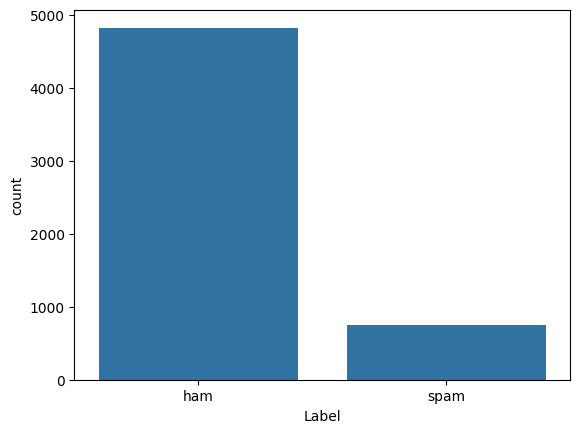

In [223]:
sns.countplot(x='Label', data=data)
plt.show()

In [224]:
data['Label'] = data['Label'].map({'ham': 0, 'spam': 1})
ham_msg = data[data.Label == 0]
spam_msg = data[data.Label == 1]
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)

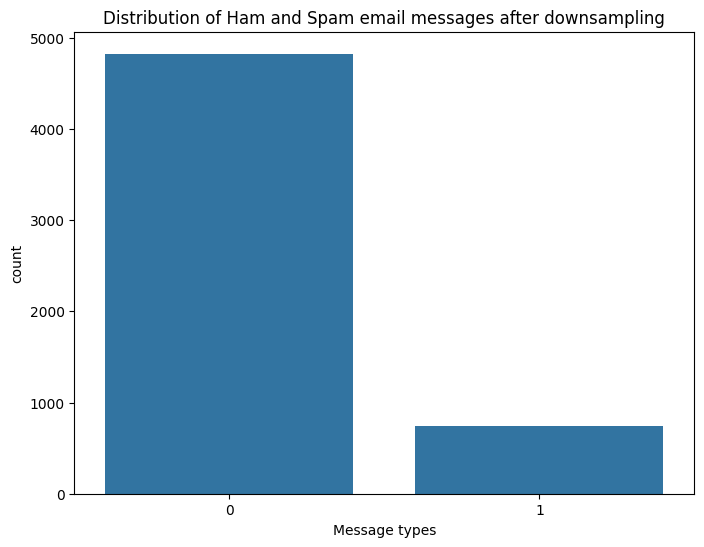

In [225]:
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='Label')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')
plt.show()

In [226]:
balanced_data['Text'] = balanced_data['Text'].str.replace('Subject', '')
balanced_data.head()

,Label,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,0,Even my brother is not like to speak with me. ...


In [227]:
balanced_data['Text']= balanced_data['Text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Label,Text
0,0,Go until jurong point crazy Available only in ...
1,0,Ok lar Joking wif u oni
2,0,U dun say so early hor U c already then say
3,0,Nah I dont think he goes to usf he lives aroun...
4,0,Even my brother is not like to speak with me T...


In [228]:
balanced_data['Text'] = balanced_data['Text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Label,Text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,0,u dun say early hor u c already say
3,0,nah dont think goes usf lives around though
4,0,even brother like speak treat like aids patent


# Example implementation

In [229]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Text'],
                                                    balanced_data['Label'],
                                                    test_size = 0.2,
                                                    random_state = 42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [230]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(LSTM(16))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'], optimizer='adam')
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20, batch_size=32, callbacks=[lr, es])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 32)           267520    
                                                                 
 lstm_10 (LSTM)              (None, 16)                3136      
                                                                 
 dense_32 (Dense)            (None, 32)                544       
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Total params: 271233 (1.03 MB)
Trainable params: 271233 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
140/140 [==============================] - 7s 36ms/step - loss: 0.4500 - accuracy: 0.8676 - val_loss: 0.4070 - val_accuracy: 0.8592 - lr: 

In [231]:
predictions = model.predict(test_sequences)
print(classification_report(test_Y, predictions.round()))

accuracy = accuracy_score(test_Y, predictions.round())
print("Accuracy: ", accuracy * 100)

35/35 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       958
           1       0.00      0.00      0.00       157

    accuracy                           0.86      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.74      0.86      0.79      1115

Accuracy:  85.91928251121075


# TF-IDF implementation

In [232]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(balanced_data['Text']).toarray()
y = balanced_data['Label']

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, random_state=42)

In [233]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(5000,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=20, batch_size=32, callbacks=[lr, es])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 128)               640128    
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 648449 (2.47 MB)
Trainable params: 648449 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


2023-12-20 05:00:51.875432: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89140000 exceeds 10% of free system memory.


140/140 [==============================] - 3s 16ms/step - loss: 0.2731 - accuracy: 0.9013 - val_loss: 0.0952 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 2/20
140/140 [==============================] - 2s 13ms/step - loss: 0.0424 - accuracy: 0.9888 - val_loss: 0.0673 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 3/20
140/140 [==============================] - 2s 13ms/step - loss: 0.0111 - accuracy: 0.9973 - val_loss: 0.0701 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/20
140/140 [==============================] - 1s 10ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0834 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/20
140/140 [==============================] - 1s 10ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0853 - val_accuracy: 0.9812 - lr: 5.0000e-04
Epoch 6/20
140/140 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0847 - val_accuracy: 0.9812 - lr: 5.0000e-04


In [234]:
predictions = model.predict(test_X)
print(classification_report(test_Y, predictions.round()))

accuracy = accuracy_score(test_Y, predictions.round())
print("Accuracy: ", accuracy * 100)

35/35 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       958
           1       0.96      0.90      0.93       157

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy:  98.11659192825111
